## Import dependecies
Import modules for

In [1]:
import os, inspect, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as ply
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import (
    train_test_split,
    KFold, cross_val_score,
    GridSearchCV,
    TimeSeriesSplit
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    mean_squared_error,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier

In [3]:
# get project root directory
curr_dir = os.path.dirname(inspect.getabsfile(inspect.currentframe()))
root_dir = os.path.dirname(curr_dir)
sys.path.insert(0, 0)

## Load data
We load the stock datasets to a pandas dataframe:

In [4]:
# load data
fname = os.path.join(root_dir, "stockomen", "data", "int", "stock.csv")
df = pd.read_csv(fname, index_col=False)
df.head(5)

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Month,Quarter,Label
0,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,8.0,3.0,0
1,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,8.0,3.0,1
2,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,8.0,3.0,0
3,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,8.0,3.0,0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,8.0,3.0,1


##  Fill missing values (the NaN values) with the column mean

In [5]:
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    df[col] = df[col].fillna(df[col].mean())

In [6]:
# Recheck the count
print(df.count())

Date            1989
Subjectivity    1989
Objectivity     1989
Positive        1989
Negative        1989
Neutral         1989
Open            1989
High            1989
Low             1989
Close           1989
Volume          1989
Adj Close       1989
Month           1989
Quarter         1989
Label           1989
dtype: int64


# Prepare train data

In [7]:
x = df.loc[:, ["Subjectivity", 
               "Objectivity",
               "Positive",
               "Negative",
               "Neutral",
               "Open",
               "High",
               "Low",
               "Close",
               "Volume",
               "Adj Close",
               "Month",
               "Quarter"]]
y = df.loc[:,'Label']
x.head()

,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Month,Quarter
0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,8.0,3.0
1,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,8.0,3.0
2,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,8.0,3.0
3,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,8.0,3.0
4,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,8.0,3.0


In [8]:
splits = TimeSeriesSplit(n_splits=3)
plt.figure(1)
index = 1
print(splits.split(x))

<generator object TimeSeriesSplit.split at 0x7ff8a8a978e0>


<Figure size 432x288 with 0 Axes>

Observations: 995
Training Observations: 498
Testing Observations: 497
Observations: 1492
Training Observations: 995
Testing Observations: 497
Observations: 1989
Training Observations: 1492
Testing Observations: 497


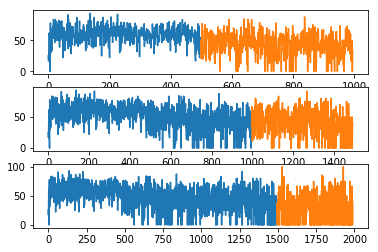

In [9]:
for x_train_index, x_test_index in splits.split(x):
    X1_train = x.loc[x_train_index, :]
    X1_test = x.loc[x_test_index, :]
    print('Observations: %d' % (len(X1_train) + len(X1_test)))
    print('Training Observations: %d' % (len(X1_train)))
    print('Testing Observations: %d' % (len(X1_test)))
    plt.subplot(310 + index)
    plt.plot(X1_train['Objectivity'])
    plt.plot([None for i in X1_train['Objectivity']] + [x for x in X1_test['Objectivity']])
    index += 1
plt.show()

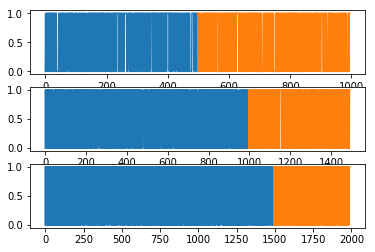

In [14]:
index = 1
#y = np.array(y)
y_ser = list(splits.split(y))
for y_train_index, y_test_index in y_ser:
    y1_train = y[y_train_index]
    y1_test = y[y_test_index]
    plt.subplot(310 + index)
    plt.plot(y1_train)
    plt.plot([None for i in y1_train] + [x for x in y1_test])
    index += 1
plt.show()

In [16]:
# define training models
models = {}
models.update({'LR': LogisticRegression()})
models.update({'LDA': LinearDiscriminantAnalysis()})
models.update({'KNN': KNeighborsClassifier()})
models.update({'CART': DecisionTreeClassifier()})
models.update({'NB': GaussianNB()})
models.update({'SVM': SVC()})
models.update({'RF': RandomForestClassifier(n_estimators=50)})
models.update({'XGBoost': XGBClassifier()})
models.update({'LDA': LinearDiscriminantAnalysis()})

In [21]:
# Evaluate each algorithm for accuracy
results = []
names = []

for name, model in models.items():
    clf1 = model
    clf1.fit(X1_train, y1_train)
    y1_pred = clf1.predict(X1_test)
    accu_score1 = accuracy_score(y1_test, y1_pred)
    print(name + ": " + str(accu_score1))

/home/aidin/miniconda3/envs/test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/home/aidin/miniconda3/envs/test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/home/aidin/miniconda3/envs/test/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



LR: 0.5191146881287726
LDA: 0.9396378269617707
KNN: 0.47484909456740443
CART: 0.5674044265593562
NB: 0.5191146881287726
SVM: 0.5171026156941649
RF: 0.5653923541247485
XGBoost: 0.5734406438631791
